In [2]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from pickle import dump
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import optuna
from xgboost import XGBClassifier
from tabulate import tabulate
import pickle

c:\Users\Linom\anaconda3\envs\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
con = sqlite3.connect('riot_matchescgmm.db')
df_matches =  pd.read_sql_query("SELECT * FROM match", con)
con.close()

In [4]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109395 entries, 0 to 109394
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            109395 non-null  int64 
 1   game_id       109395 non-null  object
 2   blue_dragons  109395 non-null  int64 
 3   blue_heralds  109395 non-null  int64 
 4   blue_barons   109395 non-null  int64 
 5   blue_turrets  109395 non-null  int64 
 6   blue_kills    109395 non-null  int64 
 7   blue_gold_20  109395 non-null  int64 
 8   red_dragons   109395 non-null  int64 
 9   red_heralds   109395 non-null  int64 
 10  red_barons    109395 non-null  int64 
 11  red_turrets   109395 non-null  int64 
 12  red_kills     109395 non-null  int64 
 13  red_gold_20   109395 non-null  int64 
 14  winner        109395 non-null  object
dtypes: int64(13), object(2)
memory usage: 12.5+ MB


In [5]:
df_matches.sample(5)

id         game_id  blue_dragons  blue_heralds  blue_barons  \
50134  50135  NA1_4612840593             1             0            0   
2801    2802  NA1_4610958198             2             1            1   
30672  30673  NA1_4603721203             2             2            0   
23482  23483  NA1_4612464601             0             1            0   
14947  14948  NA1_4598274347             1             1            0   

       blue_turrets  blue_kills  blue_gold_20  red_dragons  red_heralds  \
50134             2          20         39630            0            1   
2801              3          18         41677            1            1   
30672             5          19         41536            1            0   
23482             0           6         31100            3            0   
14947             2          12         36395            2            1   

       red_barons  red_turrets  red_kills  red_gold_20  winner  
50134           0            2         13        39283  Team 1  
2801            0            4         13        41356  Team 1  
30672           0            2          5        33421  Team 1  
23482           0            3         21        39748  Team 2  
14947           0            4         21        39885  Team 1

### Chosen Parameters
Compared to the gold-only model, this model will utilize more parameters that influence momentum and game state.
The chosen parameters are:
-Kills
-Deaths
-Assists
-Dragons
-Heralds
-Gold Difference
-Objectives(Turrets/Inhibitors)
These parameters would be calculated in each team's perspective, and then used in our different machine learning models

In [6]:
df_matches.drop_duplicates(subset=['game_id'], inplace=True)
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48861 entries, 0 to 109377
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            48861 non-null  int64 
 1   game_id       48861 non-null  object
 2   blue_dragons  48861 non-null  int64 
 3   blue_heralds  48861 non-null  int64 
 4   blue_barons   48861 non-null  int64 
 5   blue_turrets  48861 non-null  int64 
 6   blue_kills    48861 non-null  int64 
 7   blue_gold_20  48861 non-null  int64 
 8   red_dragons   48861 non-null  int64 
 9   red_heralds   48861 non-null  int64 
 10  red_barons    48861 non-null  int64 
 11  red_turrets   48861 non-null  int64 
 12  red_kills     48861 non-null  int64 
 13  red_gold_20   48861 non-null  int64 
 14  winner        48861 non-null  object
dtypes: int64(13), object(2)
memory usage: 6.0+ MB


In [7]:
df_matches.reset_index(inplace=True, drop=True)
df_matches['winner'] = df_matches.apply(lambda row:
     1 if row['winner'] == 'Team 1'
     else 0,
     axis=1
)
df_matches

id         game_id  blue_dragons  blue_heralds  blue_barons  \
0           1  NA1_4612545110             0             0            0   
1           2  NA1_4612506062             2             1            0   
2           3  NA1_4612457687             1             1            0   
3           4  NA1_4612426807             1             2            0   
4           5  NA1_4612111408             0             0            0   
...       ...             ...           ...           ...          ...   
48856  109374  NA1_4598678063             2             2            1   
48857  109375  NA1_4586081078             2             0            0   
48858  109376  NA1_4586058368             2             0            0   
48859  109377  NA1_4586050915             0             1            0   
48860  109378  NA1_4586028161             0             0            0   

       blue_turrets  blue_kills  blue_gold_20  red_dragons  red_heralds  \
0                 0          16         36685            2            2   
1                 2          23         42142            1            1   
2                 2          16         38887            2            1   
3                 4          29         44202            2            0   
4                 1          23         41487            3            2   
...             ...         ...           ...          ...          ...   
48856             4          27         46166            1            0   
48857             2           9         35431            1            2   
48858             2          16         38576            1            2   
48859             1           8         34384            3            1   
48860             1          10         34135            3            2   

       red_barons  red_turrets  red_kills  red_gold_20  winner  
0               0            4         19        44657       0  
1               0            4         15        39964       0  
2               0            2         19        39634       1  
3               0            1         15        37228       1  
4               0            6         36        51132       0  
...           ...          ...        ...          ...     ...  
48856           0            1         17        37971       1  
48857           1            4         17        42317       0  
48858           0            2         11        37027       1  
48859           0            5         14        41333       0  
48860           1            4         23        44053       0  

[48861 rows x 15 columns]

In [8]:
df_matches.iloc[:, 2:14]

blue_dragons  blue_heralds  blue_barons  blue_turrets  blue_kills  \
0                 0             0            0             0          16   
1                 2             1            0             2          23   
2                 1             1            0             2          16   
3                 1             2            0             4          29   
4                 0             0            0             1          23   
...             ...           ...          ...           ...         ...   
48856             2             2            1             4          27   
48857             2             0            0             2           9   
48858             2             0            0             2          16   
48859             0             1            0             1           8   
48860             0             0            0             1          10   

       blue_gold_20  red_dragons  red_heralds  red_barons  red_turrets  \
0             36685            2            2           0            4   
1             42142            1            1           0            4   
2             38887            2            1           0            2   
3             44202            2            0           0            1   
4             41487            3            2           0            6   
...             ...          ...          ...         ...          ...   
48856         46166            1            0           0            1   
48857         35431            1            2           1            4   
48858         38576            1            2           0            2   
48859         34384            3            1           0            5   
48860         34135            3            2           1            4   

       red_kills  red_gold_20  
0             19        44657  
1             15        39964  
2             19        39634  
3             15        37228  
4             36        51132  
...          ...          ...  
48856         17        37971  
48857         17        42317  
48858         11        37027  
48859         14        41333  
48860         23        44053  

[48861 rows x 12 columns]

In [9]:
df_features = df_matches.iloc[:, 2:14].values
feature_list = df_matches.iloc[:, 2:14].columns
df_features.shape

(48861, 12)

In [10]:
df_label = df_matches.iloc[:, -1:].values
df_label

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=0)

In [12]:
print(x_train[0:5], y_train[0:5])

[[    2     0     0     2     8 34457     1     2     1     5    21 45620]
 [    1     2     0     4    20 41589     2     0     1     1    19 38994]
 [    1     1     1     3    25 45024     2     1     0     3    27 42965]
 [    1     1     0     6    30 43903     0     1     0     0    10 33058]
 [    3     1     0     7    16 43908     0     1     0     0     7 33124]] [[0]
 [0]
 [1]
 [1]
 [1]]


In [13]:
print(x_train[1], y_train[1])

[    1     2     0     4    20 41589     2     0     1     1    19 38994] [0]


In [14]:
sc = MinMaxScaler().fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
dump(sc, open('scaler.pkl', 'wb')) # Save our mean and standard deviation for prediction

In [15]:
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=12, activation="relu"))
nn.add(tf.keras.layers.Dense(units=4, activation="relu"))
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = nn.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
1222/1222 [==============================] - 1s 655us/step - loss: 0.4528 - accuracy: 0.7944
Epoch 2/10
1222/1222 [==============================] - 1s 628us/step - loss: 0.3676 - accuracy: 0.8325
Epoch 3/10
1222/1222 [==============================] - 1s 646us/step - loss: 0.3637 - accuracy: 0.8333
Epoch 4/10
1222/1222 [==============================] - 1s 660us/step - loss: 0.3620 - accuracy: 0.8353
Epoch 5/10
1222/1222 [==============================] - 1s 633us/step - loss: 0.3610 - accuracy: 0.8352
Epoch 6/10
1222/1222 [==============================] - 1s 621us/step - loss: 0.3609 - accuracy: 0.8351
Epoch 7/10
1222/1222 [==============================] - 1s 625us/step - loss: 0.3598 - accuracy: 0.8366
Epoch 8/10
1222/1222 [==============================] - 1s 633us/step - loss: 0.3596 - accuracy: 0.8354
Epoch 9/10
1222/1222 [==============================] - 1s 677us/step - loss: 0.3593 - accuracy: 0.8374
Epoch 10/10
1222/1222 [==============================] - 1s 641u

In [16]:
NN_train, NN_test = nn.evaluate(x_train, y_train), nn.evaluate(x_test, y_test)

306/306 [==============================] - 0s 576us/step - loss: 0.3577 - accuracy: 0.8395


In [17]:
results = nn.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

77/77 [==============================] - 0s 561us/step - loss: 0.3577 - accuracy: 0.8395
test loss, test acc: [0.35767731070518494, 0.8394556641578674]


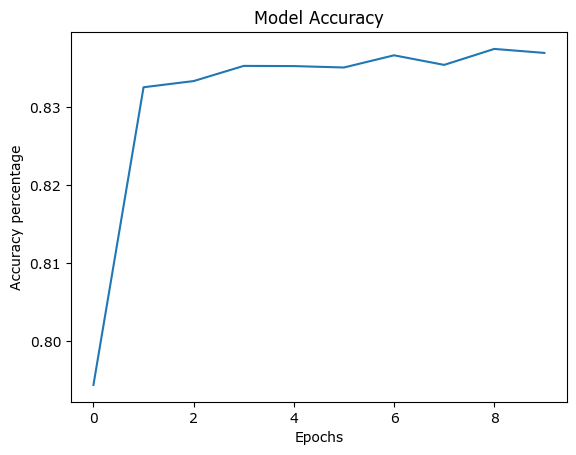

In [18]:
import matplotlib.pyplot as plt
plt.title('Model Accuracy')
plt.ylabel('Accuracy percentage')
plt.xlabel('Epochs')
plt.plot(history.history['accuracy'])
plt.show()

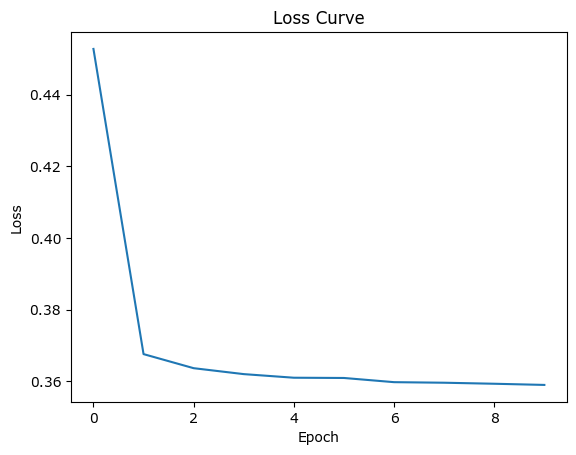

In [19]:
plt.plot(history.history['loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [20]:
nn.predict(np.array([x_train[0]]))

1/1 [==============================] - 0s 51ms/step


array([[0.0244206]], dtype=float32)

In [21]:
y_train[0]

array([0], dtype=int64)

In [22]:
y_pred = nn.predict(x_test)
y_pred = [0 if i<0.5 else 1 for i in y_pred]

306/306 [==============================] - 0s 532us/step


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

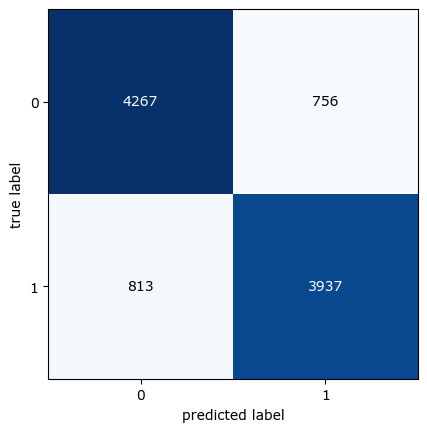

In [23]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat)

In [24]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.8379042161277118
Test Score: 0.8407858385347385


c:\Users\Linom\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
print(lg_model.coef_)
print(lg_model.intercept_)

[[ 1.10404098 -0.02167185  0.44395786  0.25563672  2.62897205  7.65203488
  -0.85630032  0.12952514 -0.49383983 -0.0401529  -2.48582869 -7.81581292]]
[-0.08987337]


In [26]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [27]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2023-04-04 16:36:28,840] A new study created in memory with name: no-name-3cb1140f-e895-4ef5-a616-9caad6634c71
[I 2023-04-04 16:36:28,940] Trial 0 finished with value: 0.7669088304512433 and parameters: {'dt_max_depth': 29, 'dt_max_features': 7}. Best is trial 0 with value: 0.7669088304512433.
[I 2023-04-04 16:36:29,026] Trial 1 finished with value: 0.8084518571574747 and parameters: {'dt_max_depth': 12, 'dt_max_features': 8}. Best is trial 1 with value: 0.8084518571574747.
[I 2023-04-04 16:36:29,076] Trial 2 finished with value: 0.827893175074184 and parameters: {'dt_max_depth': 6, 'dt_max_features': 8}. Best is trial 2 with value: 0.827893175074184.
[I 2023-04-04 16:36:29,188] Trial 3 finished with value: 0.7899314437736621 and parameters: {'dt_max_depth': 15, 'dt_max_features': 9}. Best is trial 2 with value: 0.827893175074184.
[I 2023-04-04 16:36:29,326] Trial 4 finished with value: 0.7615880487056175 and parameters: {'dt_max_depth': 31, 'dt_max_features': 10}. Best is trial 2 w

FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.8282001432518162], datetime_start=datetime.datetime(2023, 4, 4, 16, 36, 29, 695327), datetime_complete=datetime.datetime(2023, 4, 4, 16, 36, 29, 730440), params={'dt_max_depth': 9, 'dt_max_features': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=11, value=None)


In [28]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.8429697093737208
Test Score: 0.8262560114601453


In [29]:
fig = plt.figure(figsize = (200,200))
tree.plot_tree(dt, filled=True, feature_names=feature_list)
plt.savefig("output.jpg")


In [30]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [31]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

In [32]:
print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 0.8651760130986492
Test Score: 0.8360789931443774


In [33]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train.ravel())
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train.ravel())
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [34]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=20)
print(study_svm.best_trial)

[I 2023-04-04 16:37:08,867] A new study created in memory with name: no-name-9457c212-3730-43ce-862c-d203e893f7d1
[I 2023-04-04 16:37:37,329] Trial 0 finished with value: 0.836488284047887 and parameters: {'kernel': 'rbf', 'c': 0.30000000000000004}. Best is trial 0 with value: 0.836488284047887.
[I 2023-04-04 16:38:05,810] Trial 1 finished with value: 0.8368975749513967 and parameters: {'kernel': 'rbf', 'c': 0.54}. Best is trial 1 with value: 0.8368975749513967.
[I 2023-04-04 16:38:37,625] Trial 2 finished with value: 0.8350557658856032 and parameters: {'kernel': 'poly', 'c': 0.38, 'degree': 5}. Best is trial 1 with value: 0.8368975749513967.
[I 2023-04-04 16:41:39,055] Trial 3 finished with value: 0.834032538626829 and parameters: {'kernel': 'poly', 'c': 0.22, 'degree': 8}. Best is trial 1 with value: 0.8368975749513967.
[I 2023-04-04 16:41:56,176] Trial 4 finished with value: 0.8409904839864935 and parameters: {'kernel': 'linear', 'c': 0.78}. Best is trial 4 with value: 0.84099048398

FrozenTrial(number=15, state=TrialState.COMPLETE, values=[0.8411951294382483], datetime_start=datetime.datetime(2023, 4, 4, 16, 45, 32, 885345), datetime_complete=datetime.datetime(2023, 4, 4, 16, 45, 50, 296757), params={'kernel': 'linear', 'c': 0.64}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=15, value=None)


In [35]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif study_svm.best_trial.params['kernel'] == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)

c:\Users\Linom\anaconda3\envs\python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.64, kernel='linear')

In [36]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.8380321326238231
Test Score: 0.8411951294382483


In [37]:
data = [["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test], 
        ["XGBM", xgb_train, xgb_test], 
        ["SVM", SVM_train, SVM_test], 
        ["NN", NN_train[1], NN_test[1]]]

In [38]:
col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ Logistic Regression │      0.837904 │     0.840786 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.84297  │     0.826256 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      0.865176 │     0.836079 │
├─────────────────────┼───────────────┼──────────────┤
│ SVM                 │      0.838032 │     0.841195 │
├─────────────────────┼───────────────┼──────────────┤
│ NN                  │      0.837495 │     0.839456 │
╘═════════════════════╧═══════════════╧══════════════╛


In [39]:
pickle.dump(lg_model, open("Models/LG_Model.pkl", "wb"))
pickle.dump(dt, open("Models/DT_Model.pkl", "wb"))
pickle.dump(xgb_model, open("Models/XGB_Model.pkl", "wb"))
pickle.dump(SVM_model, open("Models/SVM_Model.pkl", "wb"))

# with open("Models/LG_Model.pkl", 'wb') as file:  
#     pickle.dump(lg_model, file)
# with open("Models/DT_Model.pkl", 'wb') as file:  
#     pickle.dump(dt, file)
# with open("Models/XGB_Model.pkl", 'wb') as file:  
#     pickle.dump(xgb_model, file)
# with open("Models/SVM_Model.pkl", 'wb') as file:  
#     pickle.dump(SVM_model, file)
nn.save('Models/nn_model.h5')